<a href="https://colab.research.google.com/github/rbdus0715/Machine-Learning/blob/main/study/torch/yolov1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[data](https://www.kaggle.com/datasets/mbkinaci/fruit-images-for-object-detection?resource=download)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip -qq "/content/drive/MyDrive/fruit_detection.zip"

# **Import Libraries**

In [3]:
import torch
import torch.nn as nn
import pandas as pd
import os
import PIL
import skimage
from skimage import io
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.transforms.functional as FT
from torch.utils.data import DataLoader
from tqdm import tqdm
seed = 123
import cv2
import xml.etree.ElementTree as ET
torch.manual_seed(seed)
from collections import Counter

# **Model Architecture**

In [4]:
architecture_config = [
    #Tuple: (kernel_size, number of filters, strides, padding)
    (7, 64, 2, 3),
    #"M" = Max Pool Layer
    "M",
    (3, 192, 1, 1),
    "M",
    (1, 128, 1, 0),
    (3, 256, 1, 1),
    (1, 256, 1, 0),
    (3, 512, 1, 1),
    "M",
    #List: [(tuple), (tuple), how many times to repeat]
    [(1, 256, 1, 0), (3, 512, 1, 1), 4],
    (1, 512, 1, 0),
    (3, 1024, 1, 1),
    "M",
    [(1, 512, 1, 0), (3, 1024, 1, 1), 2],
    (3, 1024, 1, 1),
    (3, 1024, 2, 1),
    (3, 1024, 1, 1),
    (3, 1024, 1, 1),
    #Doesnt include fc layers
]

In [5]:
# 기본 블럭 구성: x -> (conv) -> (batchnorm) -> (leakyrelu)
class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(CNNBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)
        self.batchnorm = nn.BatchNorm2d(out_channels)
        self.leakyrelu = nn.LeakyReLU(0.1)

    def forward(self, x):
        return self.leakyrelu(self.batchnorm(self.conv(x)))

class YoloV1(nn.Module):
    def __init__(self, in_channels=3, **kwargs):
        super(YoloV1, self).__init__()
        self.architecture = architecture_config
        self.in_channels = in_channels
        self.darknet = self._create_conv_layers(self.architecture)
        self.fcs = self._create_fcs(**kwargs)

    # Yolo: x -> (darknet) -> (flatten) -> (fcs)
    def forward(self, x):
        x = self.darknet(x)
        return self.fcs(torch.flatten(x, start_dim=1))

    def _create_conv_layers(self, architecture):
        layers = []
        in_channels = self.in_channels

        for x in architecture:
            if type(x) == tuple:
                layers += [CNNBlock(in_channels, x[1], kernel_size=x[0], stride=x[2], padding=x[3])]
                in_channels = x[1]
            elif type(x) == str:
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            elif type(x) == list:
                conv1 = x[0] #Tuple
                conv2 = x[1] #Tuple
                repeats = x[2] #Int

                for _ in range(repeats):
                    layers += [CNNBlock(in_channels, conv1[1], kernel_size=conv1[0], stride=conv1[2], padding=conv1[3])]
                    layers += [CNNBlock(conv1[1], conv2[1], kernel_size=conv2[0], stride=conv2[2], padding=conv2[3])]
                    in_channels = conv2[1]

        return nn.Sequential(*layers)

    def _create_fcs(self, split_size, num_boxes, num_classes):
        # (S = 그리드 크기, B = 바운딩 박스의 개수, C = 클래스 5종류)
        S, B, C = split_size, num_boxes, num_classes
        return nn.Sequential(
            nn.Flatten(),
            nn.Linear(1024 * S * S, 496),
            nn.Dropout(0.0),
            nn.LeakyReLU(0.1),
            nn.Linear(496, S * S * (C + B * 5))
        )
        # Original paper uses nn.Linear(1024 * S * S, 4096) not 496
        # Also the last layer will be reshaped to (S, S, 13) where C+B*5 = 13

In [6]:
# pip install torchsummary
from torchsummary import summary
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

model = YoloV1(split_size=7, num_boxes=2, num_classes=3).to(DEVICE)
summary(model, (3, 448, 448))
# output size: [-1, 637]
# 637의 근거: S * S * (C + B * 5)       # 5의 의미: (x, y, w, h, confidence)
#           = 7 * 7 * (3 + 2 * 5)
#           = 49 * 13
#           = 637

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           9,408
       BatchNorm2d-2         [-1, 64, 224, 224]             128
         LeakyReLU-3         [-1, 64, 224, 224]               0
          CNNBlock-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 192, 112, 112]         110,592
       BatchNorm2d-7        [-1, 192, 112, 112]             384
         LeakyReLU-8        [-1, 192, 112, 112]               0
          CNNBlock-9        [-1, 192, 112, 112]               0
        MaxPool2d-10          [-1, 192, 56, 56]               0
           Conv2d-11          [-1, 128, 56, 56]          24,576
      BatchNorm2d-12          [-1, 128, 56, 56]             256
        LeakyReLU-13          [-1, 128, 56, 56]               0
         CNNBlock-14          [-1, 128,

# **Utility Functions**

# **Intersection Over Union**

In [7]:
def intersection_over_union(boxes_preds, boxes_labels, box_format='midpoint'):
    """
    Calculates intersection over union

    Parameters:
        boxes_preds (tensor): Predictions of Bounding Boxes (BATCH_SIZE, 4)
        boxes_labels (tensor): Correct labels of Bounding Boxes (BATCH_SIZE, 4)
        box_format (str): midpoint/corners, if boxes are (x,y,w,h) or (x1,y1,x2,y2) respectively.

    Returns:
        tensor: Intersection over union for all examples
    """
    # boxes_preds shape is (N, 4) where N is the number of bboxes
    #boxes_labels shape is (n, 4)

    if box_format == 'midpoint':
        box1_x1 = boxes_preds[..., 0:1] - boxes_preds[..., 2:3] / 2
        box1_y1 = boxes_preds[..., 1:2] - boxes_preds[..., 3:4] / 2
        box1_x2 = boxes_preds[..., 0:1] + boxes_preds[..., 2:3] / 2
        box1_y2 = boxes_preds[..., 1:2] + boxes_preds[..., 3:4] / 2
        box2_x1 = boxes_labels[..., 0:1] - boxes_labels[..., 2:3] / 2
        box2_y1 = boxes_labels[..., 1:2] - boxes_labels[..., 3:4] / 2
        box2_x2 = boxes_labels[..., 0:1] + boxes_labels[..., 2:3] / 2
        box2_y2 = boxes_labels[..., 1:2] + boxes_labels[..., 3:4] / 2

    if box_format == 'corners':
        box1_x1 = boxes_preds[..., 0:1]
        box1_y1 = boxes_preds[..., 1:2]
        box1_x2 = boxes_preds[..., 2:3]
        box1_y2 = boxes_preds[..., 3:4] # Output tensor should be (N, 1). If we only use 3, we go to (N)
        box2_x1 = boxes_labels[..., 0:1]
        box2_y1 = boxes_labels[..., 1:2]
        box2_x2 = boxes_labels[..., 2:3]
        box2_y2 = boxes_labels[..., 3:4]

    x1 = torch.max(box1_x1, box2_x1)
    y1 = torch.max(box1_y1, box2_y1)
    x2 = torch.min(box1_x2, box2_x2)
    y2 = torch.min(box1_y2, box2_y2)

    #.clamp(0) is for the case when they don't intersect. Since when they don't intersect, one of these will be negative so that should become 0
    intersection = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)

    box1_area = abs((box1_x2 - box1_x1) * (box1_y2 - box1_y1))
    box2_area = abs((box2_x2 - box2_x1) * (box2_y2 - box2_y1))

    return intersection / (box1_area + box2_area - intersection + 1e-6)

# **Non-Max Supression**

In [8]:
def non_max_suppression(bboxes, iou_threshold, threshold, box_format="corners"):
    """
    Does Non Max Suppression given bboxes
    Parameters:
        bboxes (list): list of lists containing all bboxes with each bboxes
        specified as [class_pred, prob_score, x1, y1, x2, y2]
        iou_threshold (float): threshold where predicted bboxes is correct
        threshold (float): threshold to remove predicted bboxes (independent of IoU)
        box_format (str): "midpoint" or "corners" used to specify bboxes
    Returns:
        list: bboxes after performing NMS given a specific IoU threshold
    """

    # bboxes가 list 타입인지 확인
    assert type(bboxes) == list

    # 1. threshold 아래 값들 모두 제거
    bboxes = [box for box in bboxes if box[1] > threshold]
    # 2. confidence score에 따라 내림차순으로 정렬
    bboxes = sorted(bboxes, key=lambda x: x[1], reverse=True)
    bboxes_after_nms = []

    while bboxes:
        chosen_box = bboxes.pop(0)                          # 맨 앞 요소 pop

        bboxes = [
            box
            for box in bboxes
                if box[0] != chosen_box[0]                  # 선택한 요소와 다른 클래스를 예측했거나
                    or
                intersection_over_union(
                torch.tensor(chosen_box[2:]),
                torch.tensor(box[2:]),
                box_format=box_format,) < iou_threshold     # 선택한 요소와 iou가 일정값 밑일 때
        ]

        bboxes_after_nms.append(chosen_box)

    return bboxes_after_nms

# **Mean Average Precision**

In [9]:
def mean_average_precision(
    pred_boxes, true_boxes, iou_threshold=0.5, box_format="midpoint", num_classes=20
):
    """
    Calculates mean average precision
    Parameters:
        pred_boxes (list): list of lists containing all bboxes with each bboxes
        specified as [train_idx, class_prediction, prob_score, x1, y1, x2, y2]
        true_boxes (list): Similar as pred_boxes except all the correct ones
        iou_threshold (float): threshold where predicted bboxes is correct
        box_format (str): "midpoint" or "corners" used to specify bboxes
        num_classes (int): number of classes
    Returns:
        float: mAP value across all classes given a specific IoU threshold
    """

    # list storing all AP for respective classes
    average_precisions = []

    # used for numerical stability later on
    epsilon = 1e-6

    for c in range(num_classes):
        detections = []
        ground_truths = []

        # Go through all predictions and targets,
        # and only add the ones that belong to the
        # current class c
        for detection in pred_boxes:
            if detection[1] == c:
                detections.append(detection)

        for true_box in true_boxes:
            if true_box[1] == c:
                ground_truths.append(true_box)

        # find the amount of bboxes for each training example
        # Counter here finds how many ground truth bboxes we get
        # for each training example, so let's say img 0 has 3,
        # img 1 has 5 then we will obtain a dictionary with:
        # amount_bboxes = {0:3, 1:5}
        amount_bboxes = Counter([gt[0] for gt in ground_truths])

        # We then go through each key, val in this dictionary
        # and convert to the following (w.r.t same example):
        # ammount_bboxes = {0:torch.tensor[0,0,0], 1:torch.tensor[0,0,0,0,0]}
        for key, val in amount_bboxes.items():
            amount_bboxes[key] = torch.zeros(val)

        # sort by box probabilities which is index 2
        detections.sort(key=lambda x: x[2], reverse=True)
        TP = torch.zeros((len(detections)))
        FP = torch.zeros((len(detections)))
        total_true_bboxes = len(ground_truths)

        # If none exists for this class then we can safely skip
        if total_true_bboxes == 0:
            continue

        for detection_idx, detection in enumerate(detections):
            # Only take out the ground_truths that have the same
            # training idx as detection
            ground_truth_img = [
                bbox for bbox in ground_truths if bbox[0] == detection[0]
            ]

            num_gts = len(ground_truth_img)
            best_iou = 0

            for idx, gt in enumerate(ground_truth_img):
                iou = intersection_over_union(
                    torch.tensor(detection[3:]),
                    torch.tensor(gt[3:]),
                    box_format=box_format,
                )

                if iou > best_iou:
                    best_iou = iou
                    best_gt_idx = idx

            if best_iou > iou_threshold:
                # only detect ground truth detection once
                if amount_bboxes[detection[0]][best_gt_idx] == 0:
                    # true positive and add this bounding box to seen
                    TP[detection_idx] = 1
                    amount_bboxes[detection[0]][best_gt_idx] = 1
                else:
                    FP[detection_idx] = 1

            # if IOU is lower then the detection is a false positive
            else:
                FP[detection_idx] = 1

        TP_cumsum = torch.cumsum(TP, dim=0)
        FP_cumsum = torch.cumsum(FP, dim=0)
        recalls = TP_cumsum / (total_true_bboxes + epsilon)
        precisions = torch.divide(TP_cumsum, (TP_cumsum + FP_cumsum + epsilon))
        precisions = torch.cat((torch.tensor([1]), precisions))
        recalls = torch.cat((torch.tensor([0]), recalls))
        # torch.trapz for numerical integration
        average_precisions.append(torch.trapz(precisions, recalls))

    return sum(average_precisions) / len(average_precisions)

# **Last Utility Functions**

In [10]:
def get_bboxes(
    loader,
    model,
    iou_threshold,
    threshold,
    pred_format="cells",
    box_format="midpoint",
    device="cuda",
):
    all_pred_boxes = []
    all_true_boxes = []

    # make sure model is in eval before get bboxes
    model.eval()
    train_idx = 0

    for batch_idx, (x, labels) in enumerate(loader):
        x = x.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            predictions = model(x)

        batch_size = x.shape[0]
        true_bboxes = cellboxes_to_boxes(labels)
        bboxes = cellboxes_to_boxes(predictions)

        for idx in range(batch_size):
            nms_boxes = non_max_suppression(
                bboxes[idx],
                iou_threshold=iou_threshold,
                threshold=threshold,
                box_format=box_format,
            )


            #if batch_idx == 0 and idx == 0:
            #    plot_image(x[idx].permute(1,2,0).to("cpu"), nms_boxes)
            #    print(nms_boxes)

            for nms_box in nms_boxes:
                all_pred_boxes.append([train_idx] + nms_box)

            for box in true_bboxes[idx]:
                # many will get converted to 0 pred
                if box[1] > threshold:
                    all_true_boxes.append([train_idx] + box)

            train_idx += 1

    model.train()
    return all_pred_boxes, all_true_boxes



def convert_cellboxes(predictions, S=7, C=3):
    """
    Converts bounding boxes output from Yolo with
    an image split size of S into entire image ratios
    rather than relative to cell ratios. Tried to do this
    vectorized, but this resulted in quite difficult to read
    code... Use as a black box? Or implement a more intuitive,
    using 2 for loops iterating range(S) and convert them one
    by one, resulting in a slower but more readable implementation.
    """

    predictions = predictions.to("cpu")
    batch_size = predictions.shape[0]
    predictions = predictions.reshape(batch_size, 7, 7, C + 10)
    bboxes1 = predictions[..., C + 1:C + 5]
    bboxes2 = predictions[..., C + 6:C + 10]
    scores = torch.cat(
        (predictions[..., C].unsqueeze(0), predictions[..., C + 5].unsqueeze(0)), dim=0
    )
    best_box = scores.argmax(0).unsqueeze(-1)
    best_boxes = bboxes1 * (1 - best_box) + best_box * bboxes2
    cell_indices = torch.arange(7).repeat(batch_size, 7, 1).unsqueeze(-1)
    x = 1 / S * (best_boxes[..., :1] + cell_indices)
    y = 1 / S * (best_boxes[..., 1:2] + cell_indices.permute(0, 2, 1, 3))
    w_y = 1 / S * best_boxes[..., 2:4]
    converted_bboxes = torch.cat((x, y, w_y), dim=-1)
    predicted_class = predictions[..., :C].argmax(-1).unsqueeze(-1)
    best_confidence = torch.max(predictions[..., C], predictions[..., C + 5]).unsqueeze(
        -1
    )
    converted_preds = torch.cat(
        (predicted_class, best_confidence, converted_bboxes), dim=-1
    )

    return converted_preds


def cellboxes_to_boxes(out, S=7):
    converted_pred = convert_cellboxes(out).reshape(out.shape[0], S * S, -1)
    converted_pred[..., 0] = converted_pred[..., 0].long()
    all_bboxes = []

    for ex_idx in range(out.shape[0]):
        bboxes = []

        for bbox_idx in range(S * S):
            bboxes.append([x.item() for x in converted_pred[ex_idx, bbox_idx, :]])
        all_bboxes.append(bboxes)

    return all_bboxes

def save_checkpoint(state, filename="my_checkpoint.pth"):
    print("=> Saving checkpoint")
    torch.save(state, filename)

def load_checkpoint(checkpoint, model, optimizer):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

# **Dataset Preprocessing**

In [11]:
files_dir = './train_zip/train'
test_dir = './test_zip/test'

images = [image for image in sorted(os.listdir(files_dir))
                        if image[-4:]=='.jpg']
annots = []
for image in images:
    annot = image[:-4] + '.xml'
    annots.append(annot)

images = pd.Series(images, name='images')
annots = pd.Series(annots, name='annots')
df = pd.concat([images, annots], axis=1)
df = pd.DataFrame(df)
# df의 모습
# 0	apple_1.jpg	    apple_1.xml
# 1	apple_10.jpg	apple_10.xml
# 2	apple_11.jpg	apple_11.xml


test_images = [image for image in sorted(os.listdir(test_dir))
                        if image[-4:]=='.jpg']

test_annots = []
for image in test_images:
    annot = image[:-4] + '.xml'
    test_annots.append(annot)

test_images = pd.Series(test_images, name='test_images')
test_annots = pd.Series(test_annots, name='test_annots')
test_df = pd.concat([test_images, test_annots], axis=1)
test_df = pd.DataFrame(test_df)

In [12]:
class FruitImagesDataset(torch.utils.data.Dataset):
    def __init__(self, df=df, files_dir=files_dir, S=7, B=2, C=3, transform=None):
        self.annotations = df
        self.files_dir = files_dir
        self.transform = transform
        self.S = S
        self.B = B
        self.C = C

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        label_path = os.path.join(self.files_dir, self.annotations.iloc[index, 1])  # .xml 파일
        boxes = []
        tree = ET.parse(label_path)                                                 # .xml 파일을 파싱해서
        root = tree.getroot()                                                       # 객체로 만들기

        class_dictionary = {'apple':0, 'banana':1, 'orange':2}

        if(int(root.find('size').find('height').text) == 0):
            filename = root.find('filename').text                                   # -> apple_1.jpg
            img = Image.open(self.files_dir + '/' + filename)
            img_width, img_height = img.size

            for member in root.findall('object'):

                klass = member.find('name').text
                klass = class_dictionary[klass]

                # bounding box
                xmin = int(member.find('bndbox').find('xmin').text)
                xmax = int(member.find('bndbox').find('xmax').text)

                ymin = int(member.find('bndbox').find('ymin').text)
                ymax = int(member.find('bndbox').find('ymax').text)

                centerx = ((xmax + xmin) / 2) / img_width
                centery = ((ymax + ymin) / 2) / img_height
                boxwidth = (xmax - xmin) / img_width
                boxheight = (ymax - ymin) / img_height


                boxes.append([klass, centerx, centery, boxwidth, boxheight])

        elif(int(root.find('size').find('height').text) != 0):

            for member in root.findall('object'):

                klass = member.find('name').text
                klass = class_dictionary[klass]

                                # bounding box
                xmin = int(member.find('bndbox').find('xmin').text)
                xmax = int(member.find('bndbox').find('xmax').text)
                img_width = int(root.find('size').find('width').text)

                ymin = int(member.find('bndbox').find('ymin').text)
                ymax = int(member.find('bndbox').find('ymax').text)
                img_height = int(root.find('size').find('height').text)

                centerx = ((xmax + xmin) / 2) / img_width
                centery = ((ymax + ymin) / 2) / img_height
                boxwidth = (xmax - xmin) / img_width
                boxheight = (ymax - ymin) / img_height


                boxes.append([klass, centerx, centery, boxwidth, boxheight])


        boxes = torch.tensor(boxes)
        img_path = os.path.join(self.files_dir, self.annotations.iloc[index, 0])
        image = Image.open(img_path)
        image = image.convert("RGB")

        if self.transform:
            # image = self.transform(image)
            image, boxes = self.transform(image, boxes)

        # Convert To Cells
        label_matrix = torch.zeros((self.S, self.S, self.C + 5 * self.B))
        for box in boxes:
            class_label, x, y, width, height = box.tolist()
            class_label = int(class_label)

            # i,j represents the cell row and cell column
            i, j = int(self.S * y), int(self.S * x)
            x_cell, y_cell = self.S * x - j, self.S * y - i

            """
            Calculating the width and height of cell of bounding box,
            relative to the cell is done by the following, with
            width as the example:

            width_pixels = (width*self.image_width)
            cell_pixels = (self.image_width)

            Then to find the width relative to the cell is simply:
            width_pixels/cell_pixels, simplification leads to the
            formulas below.
            """
            width_cell, height_cell = (
                width * self.S,
                height * self.S,
            )

            # If no object already found for specific cell i,j
            # Note: This means we restrict to ONE object
            # per cell!
#             print(i, j)
            if label_matrix[i, j, self.C] == 0:
                # Set that there exists an object
                label_matrix[i, j, self.C] = 1

                # Box coordinates
                box_coordinates = torch.tensor(
                    [x_cell, y_cell, width_cell, height_cell]
                )

                label_matrix[i, j, 4:8] = box_coordinates

                # Set one hot encoding for class_label
                label_matrix[i, j, class_label] = 1

        return image, label_matrix


In [13]:
class YoloLoss(nn.Module):
    """
    Calculate the loss for yolo (v1) model
    """

    def __init__(self, S=7, B=2, C=3):
        super(YoloLoss, self).__init__()
        self.mse = nn.MSELoss(reduction="sum")

        """
        S is split size of image (in paper 7),
        B is number of boxes (in paper 2),
        C is number of classes (in paper 20, in dataset 3),
        """
        self.S = S
        self.B = B
        self.C = C

        # These are from Yolo paper, signifying how much we should
        # pay loss for no object (noobj) and the box coordinates (coord)
        self.lambda_noobj = 0.5
        self.lambda_coord = 5

    def forward(self, predictions, target):
        # predictions are shaped (BATCH_SIZE, S*S(C+B*5) when inputted
        predictions = predictions.reshape(-1, self.S, self.S, self.C + self.B * 5)

        # Calculate IoU for the two predicted bounding boxes with target bbox
        iou_b1 = intersection_over_union(predictions[..., self.C + 1:self.C + 5], target[..., self.C + 1:self.C + 5])   # 타깃값은 정답 바운딩 박스 하나밖에 없다
        iou_b2 = intersection_over_union(predictions[..., self.C + 6:self.C + 10], target[..., self.C + 1:self.C + 5])
        # iou 두 개 각각의 차원은 (B,)
        # unsquessze(0) 후에는 (1, B)
        # cat 후에는 (2, B)
        ious = torch.cat([iou_b1.unsqueeze(0), iou_b2.unsqueeze(0)], dim=0)


        iou_maxes, bestbox = torch.max(ious, dim=0)         # iou_maxes는 최댓값, bestbox는 최댓값의 인덱스
        exists_box = target[..., self.C].unsqueeze(3)       # in paper this is Iobj_i
                                                            # => (B, S, S, 1)

        # ======================== #
        #   FOR BOX COORDINATES    #
        # ======================== #

        # Set boxes with no object in them to 0. We only take out one of the two
        # predictions, which is the one with highest Iou calculated previously.
        box_predictions = exists_box * (                                                     # exists_box를 곱해줌으로서 target에 객체가 존재하는 경우만 골라줌
            (
                bestbox * predictions[..., self.C + 6:self.C + 10]                           # 각 사진마다 두 개의 바운딩 박스 중에서 iou 값이 '작은' 박스를 선택한다.
                + (1 - bestbox) * predictions[..., self.C + 1:self.C + 5]                    # 학습할 때 모델 입장에서 iou 예측을 잘 못하는 박스 때문에 비용이 증가하기 때문
            )
        )

        box_targets = exists_box * target[..., self.C + 1:self.C + 5]

        # Take sqrt of width, height of boxes to ensure that
        box_predictions[..., 2:4] = torch.sign(box_predictions[..., 2:4]) * torch.sqrt(      # torch.sign : 양수면 1, 음수면 -1, 0이면 0을 반환
            torch.abs(box_predictions[..., 2:4] + 1e-6)
        )
        box_targets[..., 2:4] = torch.sqrt(box_targets[..., 2:4])

        box_loss = self.mse(
            torch.flatten(box_predictions, end_dim=-2),                                      # flatten의 end_dim을 -2로 하여 (7, 7, 2)을 평탄화한다.
            torch.flatten(box_targets, end_dim=-2),
        )

        # ==================== #
        #   FOR OBJECT LOSS    #
        # ==================== #

        # pred_box is the confidence score for the bbox with highest IoU
        pred_box = (
            bestbox * predictions[..., self.C + 5:self.C + 6] + (1 - bestbox) * predictions[..., self.C:self.C + 1]
        )

        object_loss = self.mse(
            torch.flatten(exists_box * pred_box),
            torch.flatten(exists_box * target[..., self.C:self.C + 1]),
        )

        # ======================= #
        #   FOR NO OBJECT LOSS    #
        # ======================= #

        #max_no_obj = torch.max(predictions[..., 20:21], predictions[..., 25:26])
        #no_object_loss = self.mse(
        #    torch.flatten((1 - exists_box) * max_no_obj, start_dim=1),
        #    torch.flatten((1 - exists_box) * target[..., 20:21], start_dim=1),
        #)

        no_object_loss = self.mse(                                                                      # 존재하지 않는 걸 존재한다고 했을 경우도 비요이 증가한다.
            torch.flatten((1 - exists_box) * predictions[..., self.C:self.C + 1], start_dim=1),
            torch.flatten((1 - exists_box) * target[..., self.C:self.C + 1], start_dim=1),
        )

        no_object_loss += self.mse(
            torch.flatten((1 - exists_box) * predictions[..., self.C + 5:self.C + 6], start_dim=1),
            torch.flatten((1 - exists_box) * target[..., self.C:self.C + 1], start_dim=1)
        )

        # ================== #
        #   FOR CLASS LOSS   #
        # ================== #

        class_loss = self.mse(
            torch.flatten(exists_box * predictions[..., :self.C], end_dim=-2,),
            torch.flatten(exists_box * target[..., :self.C], end_dim=-2,),
        )

        loss = (
            self.lambda_coord * box_loss  # first two rows in paper
            + object_loss  # third row in paper
            + self.lambda_noobj * no_object_loss  # forth row
            + class_loss  # fifth row
        )

        return loss

# **Model Training**

In [14]:
LEARNING_RATE = 2e-5
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 16 # 64 in original paper but resource exhausted error otherwise.
WEIGHT_DECAY = 0
EPOCHS = 20
NUM_WORKERS = 2
PIN_MEMORY = True
LOAD_MODEL = False
LOAD_MODEL_FILE = "model.pth"

In [15]:
def train_fn(train_loader, model, optimizer, loss_fn):
    loop = tqdm(train_loader, leave=True)
    mean_loss = []

    for batch_idx, (x, y) in enumerate(loop):
        x, y = x.to(DEVICE), y.to(DEVICE)
        out = model(x)
        loss = loss_fn(out, y)
        mean_loss.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loop.set_postfix(loss = loss.item())

    print(f"Mean loss was {sum(mean_loss) / len(mean_loss)}")

In [16]:
class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img, bboxes):
        for t in self.transforms:
            img, bboxes = t(img), bboxes

        return img, bboxes


transform = Compose([transforms.Resize((448, 448)), transforms.ToTensor()])

In [17]:
def main():
    model = YoloV1(split_size=7, num_boxes=2, num_classes=3).to(DEVICE)
    optimizer = optim.Adam(
        model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    )
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, factor=0.1, patience=3, mode='max', verbose=True)
    loss_fn = YoloLoss()

    if LOAD_MODEL:
        load_checkpoint(torch.load(LOAD_MODEL_FILE), model, optimizer)

    train_dataset = FruitImagesDataset(
        transform=transform,
        files_dir=files_dir
    )

    test_dataset = FruitImagesDataset(
        transform=transform,
        files_dir=test_dir
    )

    train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        drop_last=False,
    )

    test_loader = DataLoader(
        dataset=test_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        drop_last=False,
    )

    for epoch in range(EPOCHS):
        train_fn(train_loader, model, optimizer, loss_fn)

        pred_boxes, target_boxes = get_bboxes(
            train_loader, model, iou_threshold=0.5, threshold=0.4
        )

        mean_avg_prec = mean_average_precision(
            pred_boxes, target_boxes, iou_threshold=0.5, box_format="midpoint"
        )
        print(f"Train mAP: {mean_avg_prec}")

        scheduler.step(mean_avg_prec)

    checkpoint = {
            "state_dict": model.state_dict(),
            "optimizer": optimizer.state_dict(),
    }
    save_checkpoint(checkpoint, filename=LOAD_MODEL_FILE)




if __name__ == "__main__":
    main()

 20%|██        | 3/15 [00:02<00:09,  1.22it/s, loss=1.14e+3]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 15/15 [00:09<00:00,  1.56it/s, loss=346]


Mean loss was 630.6212768554688
Train mAP: 0.0


100%|██████████| 15/15 [00:08<00:00,  1.72it/s, loss=313]


Mean loss was 282.88722839355466
Train mAP: 0.0


100%|██████████| 15/15 [00:09<00:00,  1.65it/s, loss=251]


Mean loss was 185.3016347249349
Train mAP: 0.017175082117319107


100%|██████████| 15/15 [00:09<00:00,  1.61it/s, loss=124]


Mean loss was 134.5655954996745
Train mAP: 0.06321611255407333


100%|██████████| 15/15 [00:09<00:00,  1.58it/s, loss=96.2]


Mean loss was 108.24632110595704
Train mAP: 0.1904238909482956


100%|██████████| 15/15 [00:09<00:00,  1.58it/s, loss=79.6]


Mean loss was 89.41954854329427
Train mAP: 0.2799936532974243


100%|██████████| 15/15 [00:09<00:00,  1.58it/s, loss=74]


Mean loss was 82.00116806030273
Train mAP: 0.3796011507511139


100%|██████████| 15/15 [00:09<00:00,  1.65it/s, loss=75]


Mean loss was 71.61621678670248
Train mAP: 0.45150354504585266


100%|██████████| 15/15 [00:08<00:00,  1.71it/s, loss=55.3]


Mean loss was 66.67262166341146
Train mAP: 0.5180243849754333


100%|██████████| 15/15 [00:09<00:00,  1.63it/s, loss=56.9]


Mean loss was 61.135485585530596
Train mAP: 0.5685064792633057


100%|██████████| 15/15 [00:09<00:00,  1.58it/s, loss=69.9]


Mean loss was 54.91488545735677
Train mAP: 0.6566056609153748


100%|██████████| 15/15 [00:09<00:00,  1.59it/s, loss=47.9]


Mean loss was 53.20968755086263
Train mAP: 0.6947428584098816


100%|██████████| 15/15 [00:09<00:00,  1.59it/s, loss=50.7]


Mean loss was 54.27985356648763
Train mAP: 0.7230548858642578


100%|██████████| 15/15 [00:09<00:00,  1.59it/s, loss=42.6]


Mean loss was 50.37402267456055
Train mAP: 0.815809428691864


100%|██████████| 15/15 [00:09<00:00,  1.65it/s, loss=35]


Mean loss was 50.77145589192708
Train mAP: 0.7863402366638184


100%|██████████| 15/15 [00:08<00:00,  1.71it/s, loss=47.6]


Mean loss was 53.78866449991862
Train mAP: 0.8426070213317871


100%|██████████| 15/15 [00:09<00:00,  1.61it/s, loss=56.9]


Mean loss was 47.340907923380534
Train mAP: 0.8385019898414612


100%|██████████| 15/15 [00:09<00:00,  1.58it/s, loss=50.1]


Mean loss was 42.41566467285156
Train mAP: 0.8716897368431091


100%|██████████| 15/15 [00:09<00:00,  1.60it/s, loss=35.3]


Mean loss was 38.817885335286455
Train mAP: 0.9099674224853516


100%|██████████| 15/15 [00:09<00:00,  1.57it/s, loss=50.1]


Mean loss was 39.59657287597656
Train mAP: 0.8675425052642822
=> Saving checkpoint


# **Predictions**

In [22]:
LOAD_MODEL = True
EPOCHS = 1

In [23]:
def plot_image(image, boxes):
    """Plots predicted bounding boxes on the image"""
    im = np.array(image)
    height, width, _ = im.shape

    # Create figure and axes
    fig, ax = plt.subplots(1)
    # Display the image
    ax.imshow(im)

    # box[0] is x midpoint, box[2] is width
    # box[1] is y midpoint, box[3] is height

    # Create a Rectangle potch
    for box in boxes:
        box = box[2:]
        assert len(box) == 4, "Got more values than in x, y, w, h, in a box!"
        upper_left_x = box[0] - box[2] / 2
        upper_left_y = box[1] - box[3] / 2
        rect = patches.Rectangle(
            (upper_left_x * width, upper_left_y * height),
            box[2] * width,
            box[3] * height,
            linewidth=1,
            edgecolor="r",
            facecolor="none",
        )
        # Add the patch to the Axes
        ax.add_patch(rect)

    plt.show()

=> Loading checkpoint


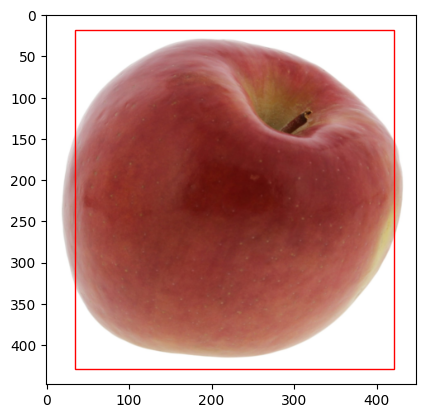

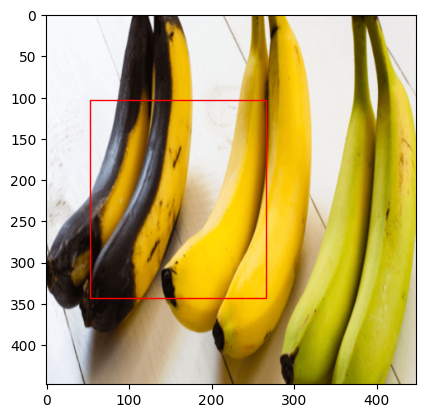

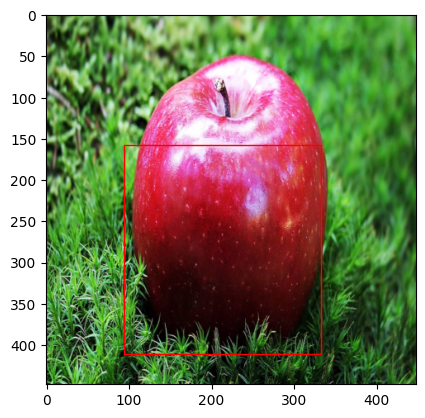

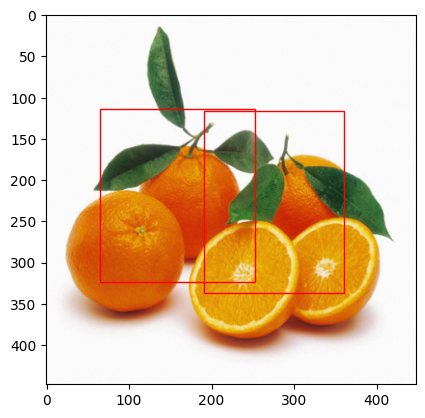

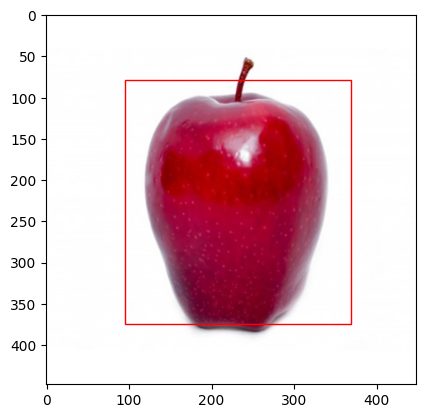

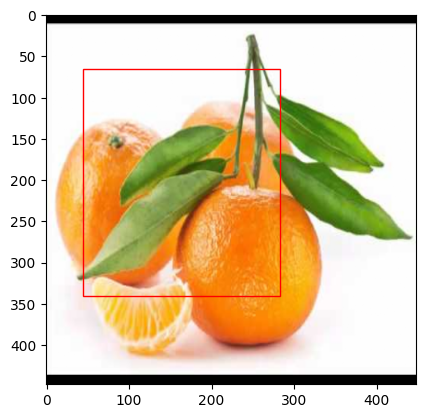

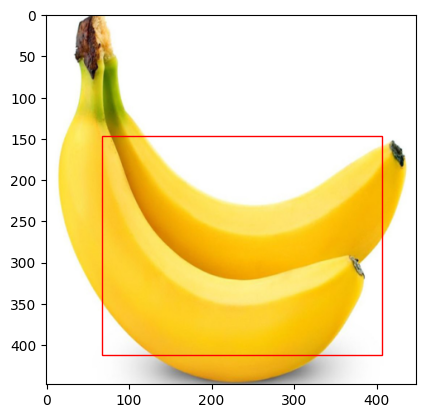

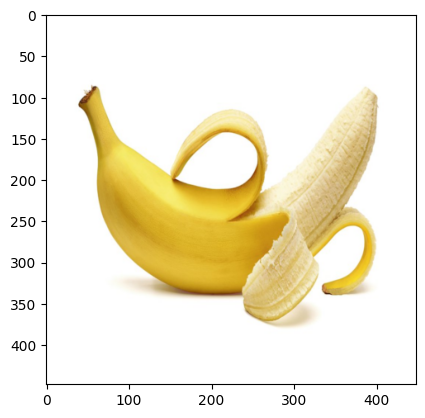

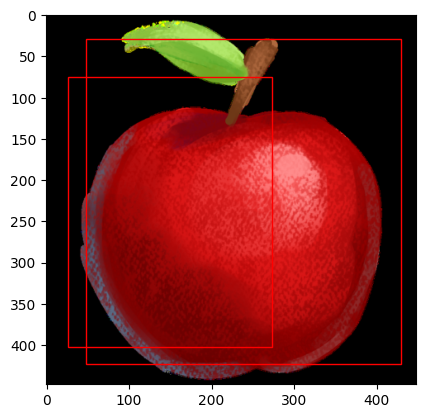

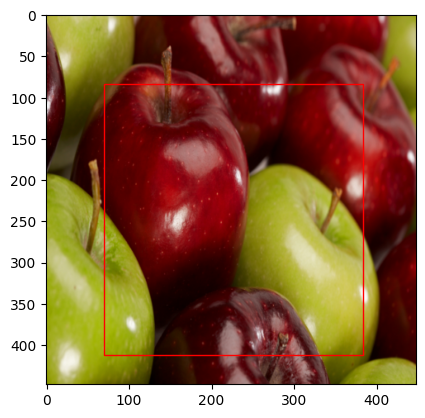

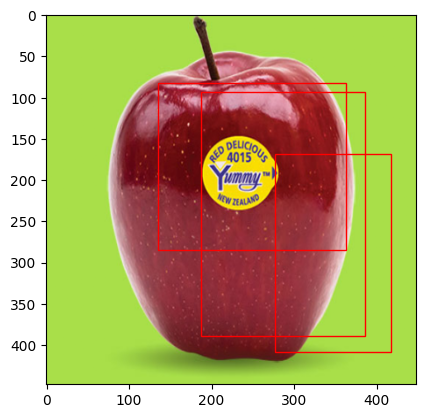

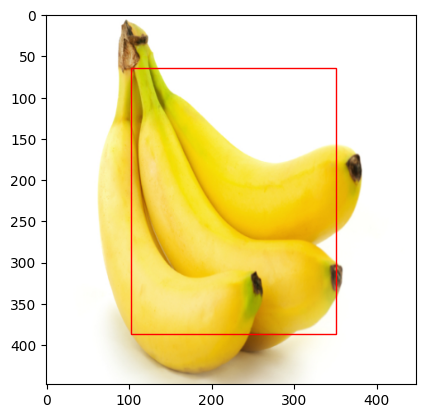

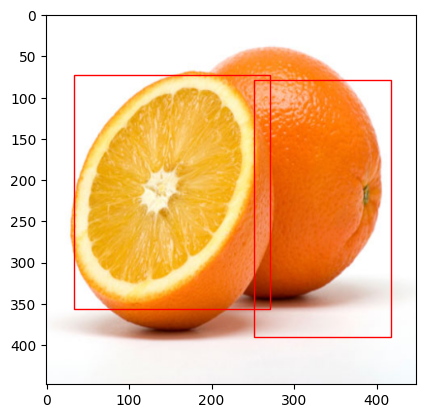

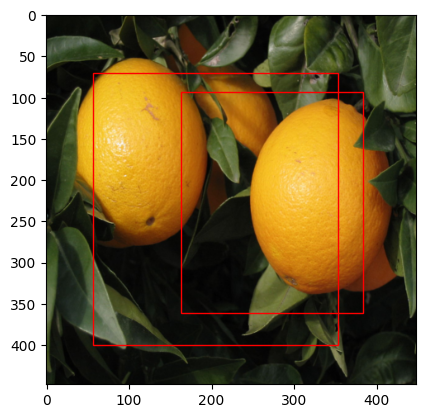

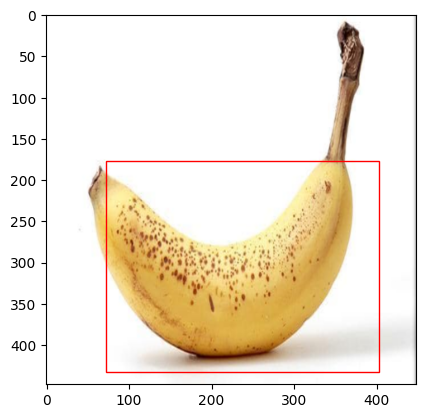

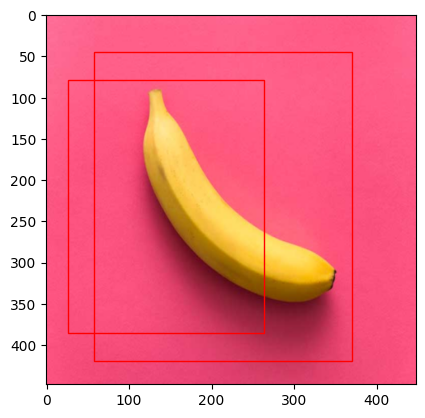

IndexError: list index out of range

In [25]:
def predictions():
    model = YoloV1(split_size=7, num_boxes=2, num_classes=3).to(DEVICE)
    optimizer = optim.Adam(
        model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    )
    loss_fn = YoloLoss()

    if LOAD_MODEL:
        load_checkpoint(torch.load(LOAD_MODEL_FILE), model, optimizer)

    test_dataset = FruitImagesDataset(
        transform=transform,
        df=test_df,
        files_dir=test_dir
    )

    test_loader = DataLoader(
        dataset=test_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        drop_last=False,
    )

    for epoch in range(EPOCHS):
        model.eval()
        for x, y in test_loader:
           x = x.to(DEVICE)
           for idx in range(18):
               bboxes = cellboxes_to_boxes(model(x))
               bboxes = non_max_suppression(bboxes[idx], iou_threshold=0.5, threshold=0.4, box_format="midpoint")
               plot_image(x[idx].permute(1,2,0).to("cpu"), bboxes)

           import sys
           sys.exit()

        pred_boxes, target_boxes = get_bboxes(
            test_loader, model, iou_threshold=0.5, threshold=0.4
        )

        mean_avg_prec = mean_average_precision(
            pred_boxes, target_boxes, iou_threshold=0.5, box_format="midpoint"
        )
        print(f"Test mAP: {mean_avg_prec}")


predictions()